In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import graphviz
# 绘制一个简单的图
dot = graphviz.Digraph()
dot.node('A', 'Hello')
dot.node('B', 'World')
dot.edge('A', 'B')
dot.render('test.gv', view=True)  # 生成并显示图形

'test.gv.pdf'

In [3]:
def  f(x):
    return  3*x**2 - 4*x + 5

In [4]:
f(3)


20

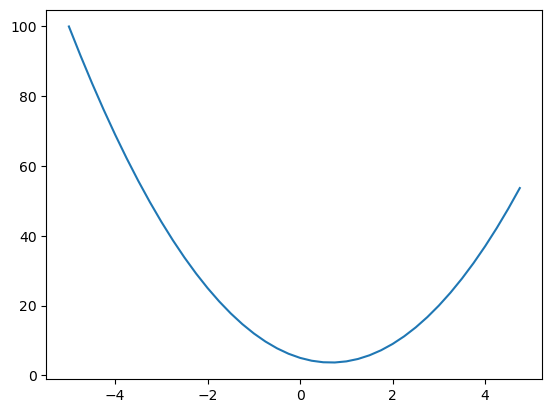

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.000000000000001
x = 3.0
(f(x+h) - f(x))/h

10.658141036401503

In [7]:
a = 2.0
b = -3.0 
c = 10.0 
d = a*b+c
print(d)

4.0


In [8]:
h = 0.00001
a = 2.0
b = -3.0 
c = 10.0 
d1 = a*b+c
a += h
d2 = a*b+c 
print("d1",d1)
print("d2",d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 3.9999699999999994
slope -3.000000000064062


In [9]:
class  Value:
    def __init__(self, data, _children=(), _op='',label=''):
        self.data = data
        self._prev = set(_children)     
        self._op = _op
        self.grad = 0.0
        self._backward = lambda: None
        self.label = label
    def __add__(self,other):    #magic methods
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other),'+')
        def _backward():
            self.grad += 1.0* out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')        
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        # 反向传播
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    def __radd__(self, other): # other + self
        return self + other
    def __rmul__(self,other):
        # 反向传播中，乘法的顺序不影响结果
        return self * other
    def __neg__(self): # -self
        return self * -1
    def __sub__(self, other): # self - other
        return self + (-other)
    def __rsub__(self, other): # other - self
        return other + (-self)
    def __rtruediv__(self, other): # other / self
        return other * self**-1
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    


In [10]:
a = Value(2.0,label='a')
b = Value(-3.0 ,label='b') 
c = Value(10.0 ,label='c')
e = a*b; e.label='e'
a.__add__(b)
a.__mul__(b)
d= e + c; d.label='d'
f = Value(-2.0 ,label='f')
L = d*f; L.label='L'

In [11]:
a = Value(3.0, label='a')
a +1
2 * a
a / b

Value(data=-1.0, grad=0.0)

In [12]:
d._prev

{Value(data=-6.0, grad=0.0), Value(data=10.0, grad=0.0)}

In [13]:
d._op

'+'

In [14]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data,n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [15]:
L.grad = 1.0
d.grad = f.data
f.grad = d.data
c.grad = d.grad
e.grad = d.grad
a.grad = b.data * e.grad
b.grad = a.data * e.grad


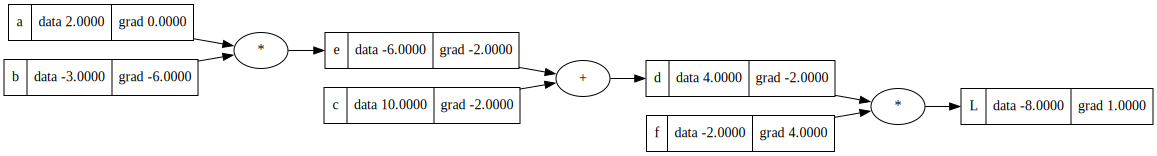

In [16]:
draw_dot(L)

In [17]:
a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
f.data += 0.01*f.grad
e = a*b
d = e + c
L = d*f
print(L.data)

-1.208144000000001


In [18]:
def lol():
    h = 0.00001
    
    a = Value(2.0,label='a')
    b = Value(-3.0 ,label='b') 
    c = Value(10.0 ,label='c')
    e = a*b; e.label='e'
    a.__add__(b)
    a.__mul__(b)
    d= e + c; d.label='d'
    f = Value(-2.0 ,label='f')
    L = d*f; L.label='L'
    L1 = L.data
    a = Value(2.0 ,label='a')
    b = Value(-3.0 ,label='b') 
    c = Value(10.0 ,label='c')
    e = a*b; e.label='e'
    a.__add__(b)
    a.__mul__(b)
    e.data += h
    d= e + c; d.label='d'
    
    f = Value(-2.0 ,label='f')
    L = d*f; L.label='L'
    L2 = L.data
    print((L2 - L1)/h)

lol()

-1.9999999999242843


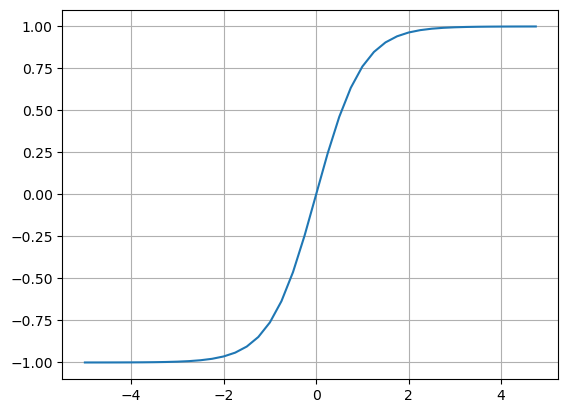

In [19]:
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25)))
plt.grid()
# 激活函数 active function

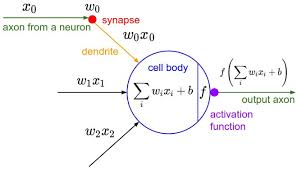

In [20]:
# input x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1,w2
w1 = Value(-3.0 ,label='w1')    
w2 = Value(1.0 ,label='w2')
# bias b of the neuron 
b = Value(6.8813735870195432 ,label='b')
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label='x1*w1' 
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1+x2w2'
n =  b + x1w1x2w2 ; n.label = 'n'
o = n.tanh() ; o.label = 'o'



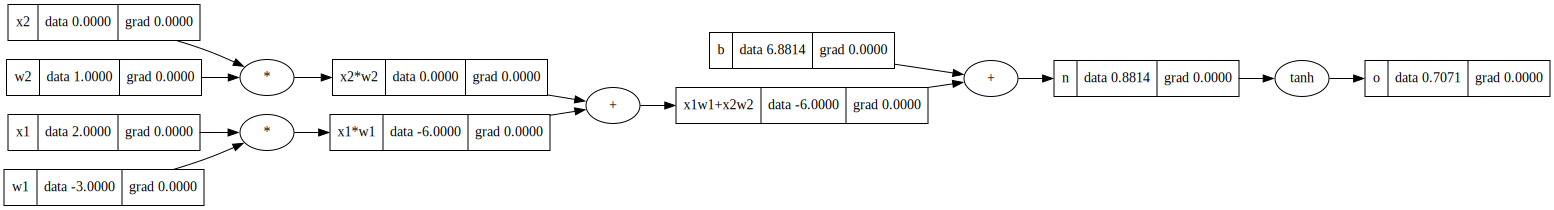

In [21]:
draw_dot(o)

In [22]:
o.backward()

In [23]:
o.grad = 1.0


In [24]:
o._backward()

In [25]:
n._backward()

In [26]:
x1w1x2w2._backward()

In [27]:
x1w1._backward()
x2w2._backward()

In [28]:
o.grad = 1.0
n.grad = 1 - o.data**2 # tanh 的导数
x1w1x2w2.grad = n.grad
b.grad = n.grad
x2w2.grad = x1w1x2w2.grad
x1w1.grad = x1w1x2w2.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad   
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad


In [29]:
o.data

0.7071067811865476

o = tanh(n)

do/dn = 1-o^2

In [30]:
1 - o.data**2

0.4999999999999999

In [31]:
o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
for v in reversed(topo):
    v._backward()

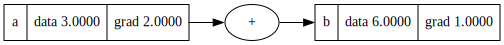

In [32]:
a = Value(3.0, label='a')
b = a + a
b.label = 'b'
b.backward()
draw_dot(b) ## big bug 

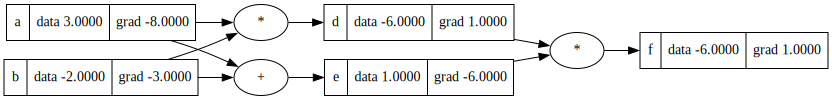

In [33]:
a = Value(3.0, label='a')
b = Value(-2.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'
f.backward()
draw_dot(f)

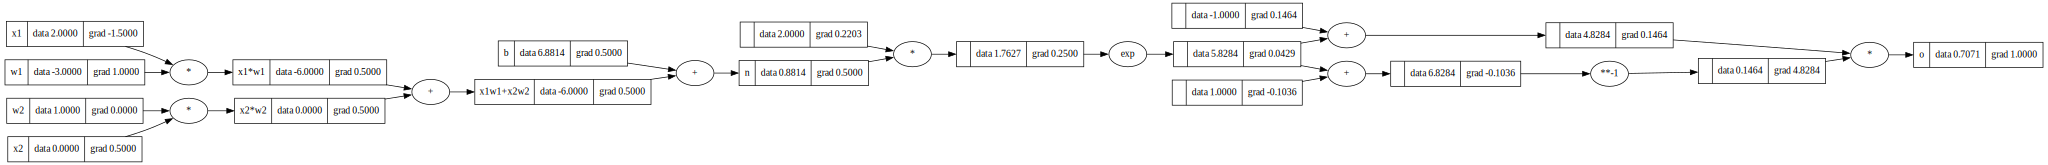

In [34]:
# input x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1,w2
w1 = Value(-3.0 ,label='w1')    
w2 = Value(1.0 ,label='w2')
# bias b of the neuron 
b = Value(6.8813735870195432 ,label='b')
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label='x1*w1' 
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1+x2w2'
n =  b + x1w1x2w2 ; n.label = 'n'
e = (2*n).exp() # 2*n 的指数函数
o = (e - 1) / (e + 1) # 双曲正切函数 tanh
o.label = 'o'
o.backward()  # 反向传播计算梯度
draw_dot(o)


# 下面讲如何在pytorch中实现反向传播


In [35]:
import torch

In [36]:
torch.tensor([2.0]).dtype # torch.tensor([2.0]) 默认是 float32
torch.tensor([2.0]).double() # 指定为 float64

tensor([2.], dtype=torch.float64)

In [37]:
import torch

# 创建叶子张量
x1 = torch.tensor([2.0]).double(); x1.requires_grad=True
x2 = torch.tensor([0.0]).double(); x2.requires_grad=True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad=True
w2 = torch.tensor([1.0]).double(); w2.requires_grad=True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad=True
# 前向传播
n = b + x1 * w1 + x2 * w2
o = torch.tanh(n)

# 打印输出
print(o.item())  # .data.item() 也可以，但不推荐使用 .data

# 反向传播
o.backward()

# 打印梯度
print('---')
print('x1', x1.grad.item())  
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [38]:
x1.grad.item()

-1.5000003851533106

In [ ]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)),self.b)  # 计算加权和并加上偏置
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b] # 返回权重和偏置参数
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]  # 创建 nout 个神经元
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]  # 每个神经元处理输入 x
        return outs[0] if len(outs) == 1 else outs  # 如果只有一个输出，返回单个值，否则返回列表
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()] # 展开所有神经元的参数列表
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts #拼接
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # 创建每一层
    def __call__(self, x):
        for layer in self.layers: 
            x = layer(x)   # 逐层处理输入 x
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()] # 展开所有层的参数列表



In [40]:
x = [2.0,3.0,4.0]
n = MLP(3,[4,4,1])  # 创建一个有3个输入和2个输出的层
n(x)
    

Value(data=-0.7188483767801823, grad=0.0)

In [41]:
n.parameters()

[Value(data=0.5606862883342347, grad=0.0),
 Value(data=0.11450204189613333, grad=0.0),
 Value(data=0.34247784482022614, grad=0.0),
 Value(data=-0.8082414095596266, grad=0.0),
 Value(data=0.7169911017450585, grad=0.0),
 Value(data=0.6727558198965446, grad=0.0),
 Value(data=0.4607541349637476, grad=0.0),
 Value(data=0.9998558589381334, grad=0.0),
 Value(data=0.33289386437599, grad=0.0),
 Value(data=-0.8634988249106457, grad=0.0),
 Value(data=-0.9314212344475612, grad=0.0),
 Value(data=0.47058201569689495, grad=0.0),
 Value(data=-0.38990968559176387, grad=0.0),
 Value(data=0.2226543125202658, grad=0.0),
 Value(data=-0.9063069659048129, grad=0.0),
 Value(data=-0.2711629841918921, grad=0.0),
 Value(data=-0.6953424124462877, grad=0.0),
 Value(data=-0.7996736658058559, grad=0.0),
 Value(data=-0.5319006279947676, grad=0.0),
 Value(data=-0.6035102054961938, grad=0.0),
 Value(data=-0.9335296629394068, grad=0.0),
 Value(data=0.6663853495577616, grad=0.0),
 Value(data=-0.9773777262577068, grad=0.0

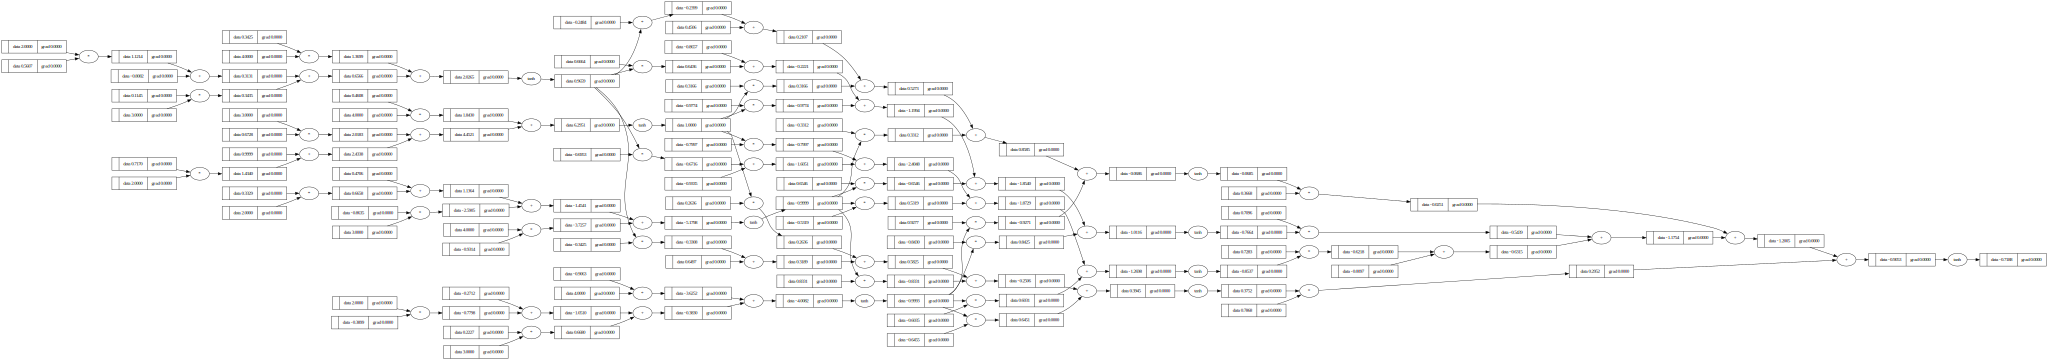

In [42]:
draw_dot(n(x))  # 绘制神经网络的计算图


下面是张量形式的神经网络，有多个预测值:
也就是说有1条神经链，分别是3个输入，两个中间层，每层4个元素
有四组训练数据

In [43]:
xs = [[2.0,3.0,-1.0],
      [3.0,-1.0,0.5],
      [0.5,1.0,1.0],
      [1.0,1.0,-1.0],]
ys = [1.0,-1.0,-1.0,1.0]
n = MLP(3,[4,4,1])  # 创建一个有3个输入和2个输出的层
n(x)

Value(data=0.7058250493642896, grad=0.0)

In [44]:
for k in range(20):
    #向前
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
    #向后
    loss.backward()
    #更新参数
    for p in n.parameters():
        p.data += -0.05 * p.grad
        p.grad = 0.0     # 清零梯度,因为梯度是累加的
    print(k, loss.data)

0 6.443919267202188
1 4.846601692709601
2 3.5506668307987144
3 2.7345170204007574
4 1.8698615690776859
5 1.3451249787984847
6 0.6704070592477263
7 0.2806942322112118
8 0.19335152620724044
9 0.15148130317280867
10 0.12380296243006966
11 0.10420177419427123
12 0.08968288375453884
13 0.07854622671661789
14 0.06976050634953901
15 0.06266822872031748
16 0.056832593146298155
17 0.05195312756567283
18 0.047816897964693766
19 0.04426909113475278


In [45]:
n.layers[0].neurons[0].w[0].grad

0.0

In [46]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
loss #向前传播

Value(data=0.04119462168021977, grad=0.0)

In [47]:
for p in n.parameters():
    p.data += -0.05 * p.grad


In [48]:
loss.backward() #向后传播

In [49]:
ypred

[Value(data=0.9429303114257134, grad=-0.11413937714857325),
 Value(data=-0.8847825291919315, grad=0.2304349416161371),
 Value(data=-0.8846513019192532, grad=0.23069739616149354),
 Value(data=0.8934294384085253, grad=-0.21314112318294942)]